In [1]:
import gpytorch
import numpy as np

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement_integral
from bo_functions import improvement_int_terms

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import error_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_integral_plot
from bo_plotters import improvement_int_terms_plot
from bo_plotters import plotter_adv_4D
from bo_plotters import y_plotter_adv_4D
from bo_plotters import stdev_plotter_adv_4D
from bo_plotters import error_plotter_adv_4D
from bo_plotters import ei_plotter_adv_4D

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.tri as mtri
import matplotlib

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19
print(test_p)

tensor([[ 1.6023, -0.3062,  1.9780],
        [ 1.3769, -0.4788, -1.4939],
        [ 0.2180, -1.6312, -1.0622],
        [ 1.7776, -1.8356, -1.6141],
        [ 0.4116, -1.0924,  0.0214],
        [-0.8668,  1.2260, -1.0091]], dtype=torch.float64)


In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Create Meshgrid
point_num = 10  #Any bigger than 10 and the kernel just dies
test_p1 = np.linspace(-2,2,point_num)
test_p2 = np.linspace(-2,2,point_num)
test_p3 = np.linspace(-2,2,point_num)

test_p_mesh = np.array(np.meshgrid(test_p1,test_p2,test_p3))
test_p_mesh_plot = test_p_mesh.T.reshape(-1,3)

In [7]:
# X, Y ,Z = test_p_mesh
# print(X.reshape(-1,4))
# data = z.reshape(point_num,point_num,point_num)

In [8]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p_mesh_plot)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p_mesh_plot, noise_std) #1x6

# print("Model Mean \n", model_mean)
# print("Model Variance \n", model_variance)
# print("Model Standard Deviation \n", model_stdev)
# print("Model y \n", model_y)
# print("Y Value Expected \n", y_exp)

# print(test_p_mesh_plot)
# print(model_y)

In [9]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
# print("best x",best_x)
# print(test_p[1])
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6

error_mag = abs(y_exp - model_y.numpy())
print("Best Error is: ",best_error)
# print("EI:",ei)
# print(ei.shape)
argmax_ei = np.argmax(ei)
print("argmax is", argmax_ei)
print("The test parameter set that gives the highest expected imrovement is \nTheta1, Theta2, x = \n")
print(test_p_mesh_plot[argmax_ei])

Best Error is:  4.6803153106264956e-05
argmax is 435
The test parameter set that gives the highest expected imrovement is 
Theta1, Theta2, x = 

[-0.66666667  0.22222222 -0.22222222]


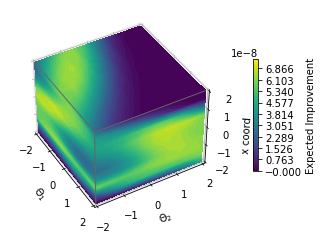

None


In [10]:
print(ei_plotter_adv_4D(test_p_mesh, ei, point_num))
# for i in range (len(test_p_mesh_plot)):
#     print(test_p_mesh_plot[i], ei[i], "\n")

## Analysis of Expected Improvement
 - Expected Improvement is largest farther from the edges
  - This is rational because you can't explore any further than the edges
 - Expected Improvement increases as error decreases
  - This is rational because as error decreases, more exploitation is possible
 - This means we are most likely to sample in the middle, farthet from the edges


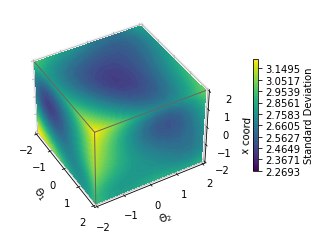

None


In [11]:
print(stdev_plotter_adv_4D(test_p_mesh, model_stdev, point_num))

## Analysis of Standard Deviation
 - The GP estimates that the standard deviation is lowest at points that were directly tested
  - This can be rationalized by the way that the contour plot is drawn
 - Standard deviation is smallest away from the edges and larger towards them
  - This is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The more points that get tested, the more the standard deviations will decrease

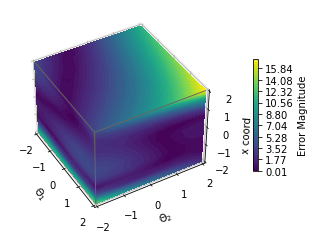

None


In [12]:
print(error_plotter_adv_4D(test_p_mesh, model_y, y_exp, point_num))

## Analysis of Error Magnitude
 - The GP emulator is most inaccurate when all values of $\bar{p}$ are at their maximum. 
  - In general, the GP is less accurate at extreme points, this is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The GP emulator is most accurate when x is at it's maximum, but $\bar{\Theta}= 0$
  - This is rationalized by the fact that multiple terms become zero if any of the values of $\bar{p}$ are zero 
 - GP error is mostly very high, as more iterations are added, these will decrease

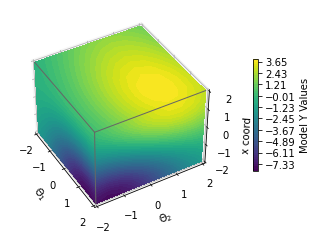

None


In [13]:
y_title = "Model Y Values"
print(y_plotter_adv_4D(test_p_mesh, model_y, point_num,y_title,yval=False))

## Analysis of GP Emulator (Model y)
 - The GP emulator correctly captures that y increases as $\bar{p}$ increases. This tells us that this GP emulator model could be viable
  - The GP emulator correctly estimates where the lowest y is achieved, but not the actual value of y
  - The GP emulator slightly mistakes where the most positive value of y is, and does not predict the actual value of y
 - The model as it is is inaccurate, BO should increase the accuracy of the emulator

In [14]:
# print(ei_plotter_adv(test_p_mesh_plot, ei))

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'},figsize=(11,8))

X, Y, Z = np.array(np.meshgrid(test_p1,test_p2,test_p3))
X = X.reshape(-1,point_num)
Y = Y.reshape(-1,point_num)
Z = Z.reshape(-1,point_num)
print(X.shape)
C = ei.T.reshape(-1,point_num)
print(C.shape)
scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(C)
ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
fig.colorbar(scamap, label = "Yelling")
ax.set_xlabel('$\Theta_1$')
ax.set_ylabel('$\Theta_2$')
ax.set_zlabel('X Coordinate')
ax.view_init(40, -30)
plt.show()

(100, 10)
(100, 10)
